# Sintonización de reglas en un spam filter

**Alumno:** VASQUEZ RAMOS, Jose Manuel

**Fecha:** 20/05/2025

___

## Contexto académico & objetivo

Sintonización de reglas en un spam filter para correos institucionales (dataset tokenizado). Evoluciona umbrales de puntaje y pesos de 5 características con DEAP y operador de hill climbing por individuo.

## Indicaciones clave

1) Genotipo: 6 floats.
2) Cada individuo aplica hill climbing local tras mutar.
3) Fitness = F1-score sobre conjunto validación.
4) Entrega mejores pesos y gráfica de F1 vs generación.

## Librerías

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.metrics import f1_score
import pandas as pd

## Aleatoriedad

In [2]:
random.seed(42)
np.random.seed(42)

## Dataset

In [3]:
def load_dataset(filename):
    data = pd.read_csv(filename)
    features = data[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5']].values
    labels = data['Spam'].values
    return features, labels

## Dividir en entrenamiento y validación (80-20)

In [4]:
features, labels = load_dataset('dataset/emails.csv')
split_idx = int(0.8 * len(features))
train_features, val_features = features[:split_idx], features[split_idx:]
train_labels, val_labels = labels[:split_idx], labels[split_idx:]

## Definición del problema en DEAP

In [5]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

## Genotipo: 6 floats (umbral + 5 pesos de características)

In [6]:
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=6)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Función de evaluación (F1-score)

In [7]:
def evaluate(individual):
    threshold = individual[0]
    weights = individual[1:]

    # Calcular puntaje ponderado para cada email
    weighted_scores = np.dot(train_features, weights)

    # Predecir spam (1) o no spam (0) basado en el umbral
    predictions = (weighted_scores > threshold).astype(int)

    # Calcular F1-score
    f1 = f1_score(train_labels, predictions)

    return (f1,)

toolbox.register("evaluate", evaluate)

## Operadores genéticos con mutación personalizada + hill climbing

In [8]:
def mut_with_hillclimbing(individual, indpb=0.1):
    # Mutación estándar
    for i in range(len(individual)):
        if random.random() < indpb:
            individual[i] = random.uniform(0, 1)

    # Hill climbing local: probar pequeñas variaciones alrededor
    best_fitness = evaluate(individual)[0]
    best_individual = list(individual)

    for _ in range(5):  # Número de vecinos a explorar
        neighbor = list(individual)
        for i in range(len(neighbor)):
            neighbor[i] += random.gauss(0, 0.05)
            neighbor[i] = np.clip(neighbor[i], 0, 1)  # Mantener en [0,1]

        neighbor_fitness = evaluate(neighbor)[0]
        if neighbor_fitness > best_fitness:
            best_fitness = neighbor_fitness
            best_individual = neighbor

    # DEVOLVER como tupla (el operador mutate de DEAP espera una tupla)
    return (creator.Individual(best_individual),)

# Registrar la función de mutación corregida
toolbox.register("mutate", mut_with_hillclimbing, indpb=0.2)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

## Algoritmo evolutivo

In [9]:
def run_evolution():
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # Registrar F1 en validación para el mejor individuo
    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + stats.fields + ["val_f1"]

    # Función para evaluar en validación
    def eval_validation(individual):
        threshold = individual[0]
        weights = individual[1:]
        weighted_scores = np.dot(val_features, weights)
        predictions = (weighted_scores > threshold).astype(int)
        return f1_score(val_labels, predictions)

    for gen in range(30):  # Número de generaciones
        offspring = algorithms.varAnd(pop, toolbox, cxpb=0.7, mutpb=0.3)

        # Evaluar fitness en entrenamiento
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        # Seleccionar nueva población
        pop = toolbox.select(offspring, k=len(pop))

        # Actualizar hall of fame y estadísticas
        hof.update(pop)
        record = stats.compile(pop)

        # Calcular F1 en validación para el mejor
        val_f1 = eval_validation(hof[0])
        logbook.record(gen=gen, nevals=len(offspring), val_f1=val_f1, **record)

        print(logbook.stream)

    return pop, hof, logbook

## Ejecución

In [11]:
pop, hof, logbook = run_evolution()

# Mostrar mejores pesos encontrados
best_individual = hof[0]
print("\nMejores pesos encontrados:")
print(f"Umbral: {best_individual[0]:.4f}")
for i, weight in enumerate(best_individual[1:], 1):
    print(f"Peso Feature{i}: {weight:.4f}")

gen	nevals	avg     	min     	max     	val_f1  
0  	50    	0.709041	0.678571	0.720721	0.666667
1  	50    	0.713125	0.694215	0.725664	0.631579
2  	50    	0.713401	0.699187	0.720721	0.631579
3  	50    	0.71379 	0.699187	0.721311	0.631579
4  	50    	0.716187	0.709677	0.727273	0.48    
5  	50    	0.717053	0.709677	0.727273	0.48    
6  	50    	0.716199	0.709677	0.727273	0.48    
7  	50    	0.71763 	0.709677	0.727273	0.48    
8  	50    	0.719354	0.704918	0.725664	0.48    
9  	50    	0.720686	0.715447	0.728814	0.5     
10 	50    	0.720923	0.709677	0.727273	0.5     
11 	50    	0.721557	0.709677	0.727273	0.5     
12 	50    	0.725008	0.717949	0.733333	0.521739
13 	50    	0.727334	0.721311	0.733333	0.521739
14 	50    	0.726585	0.716667	0.733333	0.521739
15 	50    	0.727319	0.715447	0.735043	0.545455
16 	50    	0.727991	0.706897	0.733333	0.545455
17 	50    	0.730081	0.716667	0.733333	0.545455
18 	50    	0.729876	0.672566	0.733333	0.545455
19 	50    	0.730227	0.701754	0.733333	0.545455
20 	50    	0.

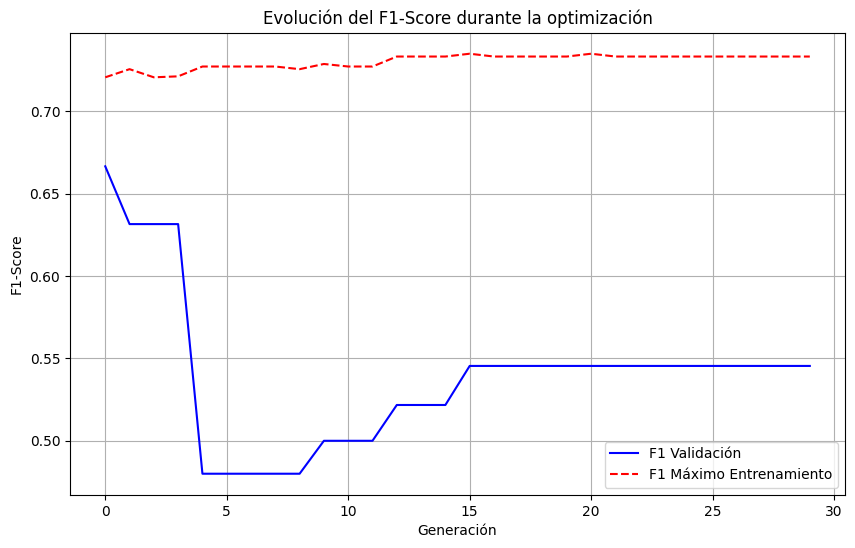

In [12]:
gen = logbook.select("gen")
val_f1 = logbook.select("val_f1")
max_f1 = logbook.select("max")

plt.figure(figsize=(10, 6))
plt.plot(gen, val_f1, 'b-', label="F1 Validación")
plt.plot(gen, max_f1, 'r--', label="F1 Máximo Entrenamiento")
plt.xlabel("Generación")
plt.ylabel("F1-Score")
plt.title("Evolución del F1-Score durante la optimización")
plt.legend()
plt.grid()
plt.show()